In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

In [231]:
def get_new_papers(labelled_data, fetched_pages) : 
    left_join = pd.merge(
        fetched_pages,
        labelled_data,
        on="url",
        how="left",
        suffixes=("", "_labelled"), 
        indicator=True,
    )
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]
    only_in_fetched = left_join[left_join["_merge"] == "left_only"].drop(columns=["_merge"])
    return(only_in_fetched)

def get_already_labelled_papers(original_dataset, fetched_pages):
    left_join = pd.merge(
        fetched_pages,
        original_dataset,
        on="url",
        how="left",
        suffixes=("", "_labelled"),
        indicator=True,
    )
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]
    already_labelled = left_join[left_join["_merge"] == "both"].drop(columns=["_merge"])
    already_labelled.drop(columns=["relevance"], inplace=True)
    return already_labelled

def get_topk_threshold(fetched_pages, top_k):
    sorted_pages = fetched_pages.sort_values(by='score', ascending=False)
    if top_k > len(sorted_pages):
        topk_score = sorted_pages.iloc[-1]['score']
    else : 
        topk_score = sorted_pages.iloc[top_k - 1]['score']
    return(topk_score)

def keep_above_threshold(thresholds,fetched_pages):
    kept = fetched_pages[fetched_pages['score'] >= thresholds]
    return(kept)

def remove_duplicates(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

def sep_by_query(session_infos, fetched_pages):
    papers_by_query = {}
    queries = remove_duplicates(list(session_infos['all_queries'])[0].split(';'))
    
    for query in queries:
        papers = fetched_pages[fetched_pages['get_with_query'] == query]
        papers_by_query[query]=papers
    return(papers_by_query)

def get_cumulative_papers(query_dict):
    cumulative_papers = {}
    seen_papers = pd.DataFrame()  # DataFrame initial pour cumuler les papiers
    for query, papers in query_dict.items():
        # Ajouter les nouveaux papiers
        seen_papers = pd.concat([seen_papers, papers]).drop_duplicates().reset_index(drop=True)
        # Créer un DataFrame pour la query en cours avec les colonnes des DataFrames originaux
        cumulative_papers[query] = seen_papers.copy()
    return cumulative_papers

def keep_topk_by_query(session_infos, fetched_pages, top_k):
    papers_by_query = sep_by_query(session_infos, fetched_pages)
    cumulative_papers_by_query = get_cumulative_papers(papers_by_query)
    kept_papers_by_query = {}
    for query, papers in cumulative_papers_by_query.items() : 
        threshold = get_topk_threshold(papers, top_k)
        kept_papers = keep_above_threshold(threshold, papers)
        # print(f'nb pages found to query:{len(papers)}')
        # print(f'nb papers kept by query : {len(kept_papers)}')
        kept_papers_by_query[query]=kept_papers
    return(kept_papers_by_query)

def recall_precision(fetched_pages, labelled_dataset) : 
    labelled_data_relevants = labelled_dataset[labelled_dataset['relevance']==1]
    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]
    recall = len(relevants) / len(labelled_data_relevants) if len(labelled_data_relevants) > 0 else 0
    precision = len(relevants) / len(merged_data) if len(merged_data) > 0 else 0
    return(recall, precision)

def get_relevants(fetched_pages, labelled_dataset):
    labelled_data_relevants = labelled_dataset[labelled_dataset['relevance']==1]
    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]
    return(relevants)

In [284]:
initial_query = 'RAG_AND_"code_generation"/'
# initial_query = '"Machine_Learning"_AND_(diffusion_OR_diffusivity)_AND_(MOFs_OR_ZIFs_OR_"metal-organic_frameworks"_OR_COFs_OR_"covalent-organic_frameworks)/'
# initial_query = '"metal-organic_frameworks"_AND_"material_design"_AND_"properties"/'

base_path = f'/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/results/{initial_query}'
original_dataset = pd.read_csv(base_path +'original_dataset.csv', sep=';')
labelled_new_papers_path =base_path + "new_papers_to_label.csv"
path_baseline = base_path + 'baseline/'
path_seed_query_expand = base_path + 'SeedQueryBasedTemplate__/'
path_most_relevant_expand = base_path + 'MostRelevantPagesBasedTemplate_MostRelevantPagesPromptBasedTemplate_HydeBasedTemplate/'
path_most_relevant_expand_hyde_prompt = base_path + 'MostRelevantPagesPromptBasedTemplate_HydeSimilarityClassifier_HydePromptBasedTemplate/'
path_seed_query_expand_hyde_prompt = base_path + 'SeedQueryPromptBasedTemplate_HydeSimilarityClassifier_HydePromptBasedTemplate/'
crawlers = {'baseline':path_baseline,
            'seed_query_expand_sim_cos':path_seed_query_expand+'sim_cos/',
            'seed_query_expand_hyde_sim_cos':path_seed_query_expand+'hyde_sim_cos/',
            'most_relevant_expand_hyde_sim_cos':path_most_relevant_expand,
            'most_relevant_expand_hyde_sim_cos_with_prompt':path_most_relevant_expand_hyde_prompt,
            'seed_query_expand_hyde_sim_cos_with_prompt':path_seed_query_expand_hyde_prompt}

top_k = 50

In [280]:
# session_infos = pd.read_csv(path_seed_query_expand+'hyde_sim_cos/' + 'session.csv', sep=',')
# print(session_infos.columns)
# session_infos.to_csv(path_seed_query_expand+'hyde_sim_cos/' + 'session.csv', index=False)

fetch_hyde = pd.read_csv(path_seed_query_expand+'hyde_sim_cos/' + 'fetched_pages.csv', sep=',')
fetch_hyde.head()

,url,title,description,score,get_with_query,time_fetch,is_seed
https://chemrxiv.org/engage/chemrxiv/article-details/642c2e0a16782ec9e6557a3e,Inverse Design of ZIFs through Artificial Inte...,Artificial Intelligence (AI) benefits research...,na,"""Machine Learning"" AND (diffusion OR diffusivi...",2024-11-22 19:01:58.627072,False,0.933655
https://chemrxiv.org/engage/chemrxiv/article-details/6492e53524989702c2b7a38d,Exploring Propane/Propylene Separation through...,Propylene is a vital component for the petroch...,na,"""Machine Learning"" AND (diffusion OR diffusivi...",2024-11-22 19:01:58.627517,False,0.933120
https://chemrxiv.org/engage/chemrxiv/article-details/66bef373a4e53c4876893d9f,Towards a Generalizable Machine-Learned\nPoten...,Machine-learned Potentials (MLPs) have transfo...,na,"""Machine Learning"" AND (diffusion OR diffusivi...",2024-11-22 19:01:58.627746,False,0.914314
https://chemrxiv.org/engage/chemrxiv/article-details/67377a797be152b1d02ff7ef,Molecular diffusion enhanced performance evalu...,Molecular diffusion is a fundamental property ...,na,"""Machine Learning"" AND (diffusion OR diffusivi...",2024-11-22 19:01:58.628227,False,0.941978
https://chemrxiv.org/engage/chemrxiv/article-details/65d66b9e66c138172931b057,Machine Learning-driven models for predicting ...,This study advances the discourse on the appli...,na,"""Machine Learning"" AND (diffusion OR diffusivi...",2024-11-22 19:01:58.628425,False,0.930796


In [288]:
df = pd.read_csv(labelled_new_papers_path, sep=',')
# df.to_csv(labelled_new_papers_path, index=False)
df.columns

Index(['url', 'title', 'description', 'relevance'], dtype='object')

In [49]:
# def reform_sessions_infos(crawler_path):
#     df = pd.read_csv(crawler_path +'session_infos.csv')
#     session_name = str(df['session_name'].iloc[0])
#     searcher = str(df['searcher'].iloc[0])
#     query_expansion = str(df['query_expansion'].iloc[0])
#     classifier = str(df['classifier'].iloc[0])
#     queries = str(df['nb_pages_per_request'].iloc[0])
#     nb_seed_pages = str(df['stop_criteria'].iloc[0])
#     duration = str(df['all_queries'].iloc[0])
#     hyde = str(df['threshold'].iloc[0])
#     nb_fetched_pages = str(df['hyde'].iloc[0])
#     cols = ['session_name', 'searcher', 'query_expansion', 'classifier', 'all_queries', 'nb_seed_pages', 'duration', 'hyde', 'nb_fetched_pages']
#     line = [session_name, searcher, query_expansion, classifier, queries, nb_seed_pages, duration, hyde, nb_fetched_pages]
#     new_df = pd.DataFrame([line], columns=cols)
#     return(new_df)

# for crawler, path in crawlers.items() : 
#     df = reform_sessions_infos(path)
#     df.to_csv(path+'session.csv')

In [289]:
## get all new fetched papers 

all_new_papers = []
for crawler, path in crawlers.items() : 
    print(crawler)
    fetched_pages = pd.read_csv(path + 'fetched_pages.csv')
    session_infos = pd.read_csv(path + 'session.csv')

    if crawler == 'baseline':
        all_kept_papers = fetched_pages.iloc[:100]
    else : 
        kept_papers_by_query = keep_topk_by_query(session_infos, fetched_pages, top_k)
        all_kept_papers = pd.concat(kept_papers_by_query.values(), ignore_index=True)
    new_papers = get_new_papers(original_dataset, all_kept_papers)
    print(len(new_papers))
    all_new_papers.append(new_papers)

combined_new_papers = pd.concat(all_new_papers, ignore_index=True)
combined_new_papers = combined_new_papers.drop_duplicates(subset=["url"], keep="first")

if os.path.exists(labelled_new_papers_path):
    try : 
        labelled_new_papers = pd.read_csv(labelled_new_papers_path, sep=';')  
    except : 
        labelled_new_papers = pd.read_csv(labelled_new_papers_path, sep=',')  
    combined_new_papers = pd.concat([combined_new_papers,labelled_new_papers], ignore_index=True)
    combined_new_papers["has_relevance"] = combined_new_papers["relevance"].notna()
    combined_new_papers = combined_new_papers.sort_values(by="has_relevance", ascending=False)
    combined_new_papers = combined_new_papers.drop_duplicates(subset=["url"])
    
columns_to_keep = ["url", "title", "description", "relevance"]
combined_new_papers = combined_new_papers.loc[:, columns_to_keep]
combined_new_papers.to_csv(base_path + "new_papers_to_label.csv", index=False)

missing_relevance = combined_new_papers[combined_new_papers['relevance'].isna()]
print(f'{len(missing_relevance)} papers to label')
    





baseline
0
seed_query_expand_sim_cos
450
seed_query_expand_hyde_sim_cos
384
most_relevant_expand_hyde_sim_cos
404
most_relevant_expand_hyde_sim_cos_with_prompt
420
seed_query_expand_hyde_sim_cos_with_prompt
422
0 papers to label


/var/folders/_q/jwd73s_9411cb6x2cl1l9q700000gn/T/ipykernel_38691/3342182101.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_new_papers = pd.concat(all_new_papers, ignore_index=True)


In [201]:
def plot_recall_precision(fig,ax,labelled_dataset,kept_papers_by_query, color='blue', crawler='crawler', plot_recall=True, plot_precision=True):
    recalls = []
    precisions = []
    query_indices = []
    i = 1
    for query, papers in kept_papers_by_query.items():       
        recall, precision = recall_precision(papers, labelled_dataset)
        recalls.append(recall)
        precisions.append(precision)
        query_indices.append(i)
        i += 1

    # Création de la figure et des courbes

    if plot_recall : 
        ax.plot(query_indices, recalls, label='recall for ' + crawler, color=color, linestyle='-', marker='o')
    if plot_precision : 
        ax.plot(query_indices, precisions, label='precision for ' + crawler, color=color, linestyle='--', marker='x')

    title = ''
    if plot_recall and plot_precision : 
        title = 'Recall and Precision per query'
    if plot_recall and not plot_precision :
        title = 'Recall per query'
    if not plot_recall and plot_precision :
        title = 'Precision per query'
    ax.set_xlabel("Query Index", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(query_indices)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend()
    
    # Retourne l'objet figure
    return fig, ax

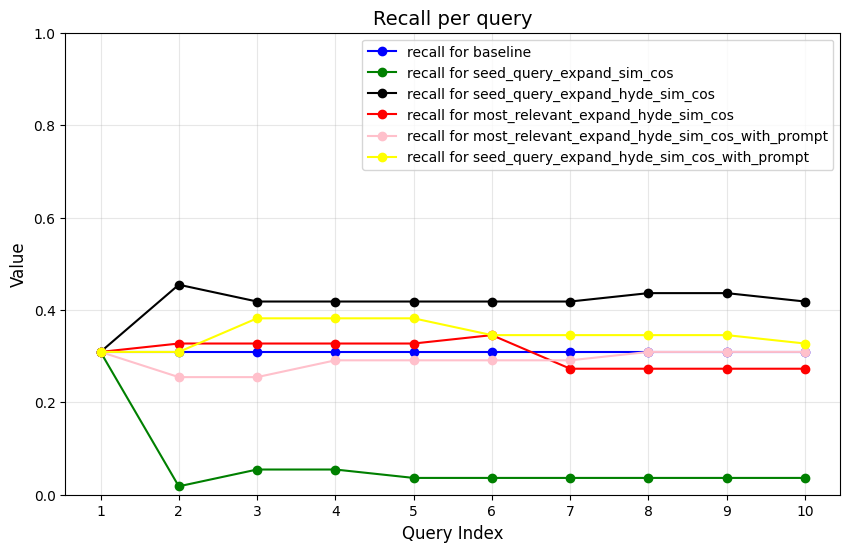

In [291]:
labelled_new_papers = pd.read_csv(labelled_new_papers_path)
labelled_dataset = pd.concat([labelled_new_papers,original_dataset], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'green', 'black', 'red', 'pink', 'yellow']

i=0
for crawler, path in crawlers.items(): 
    fetched_pages = pd.read_csv(path + 'fetched_pages.csv')
    session_infos = pd.read_csv(path + 'session.csv')
    color = colors[i]
    if crawler == 'baseline':
        query = list(session_infos['all_queries'])[0]
        # kept_papers_by_query = {query:fetched_pages.iloc[:100]}
        kept_papers_by_query = {f"{query}_{i}": fetched_pages.iloc[:100] for i in range(10)}
    else : 
        kept_papers_by_query = keep_topk_by_query(session_infos, fetched_pages, top_k)
    fig, ax = plot_recall_precision(fig, ax,labelled_dataset, kept_papers_by_query, color, crawler, plot_recall=True, plot_precision=False)
    i+=1
plt.show()

nb pages total of original dataset:24
nb relevant pages of original dataset:17
nb pages total of labelled dataset:264
nb relevant pages of labelled dataset:55
---For 50 presented to the expert---
baseline
nb pages found in total by crawler :24
nb relevant pages found in total by crawler :17
Position of last relevant pages : 21


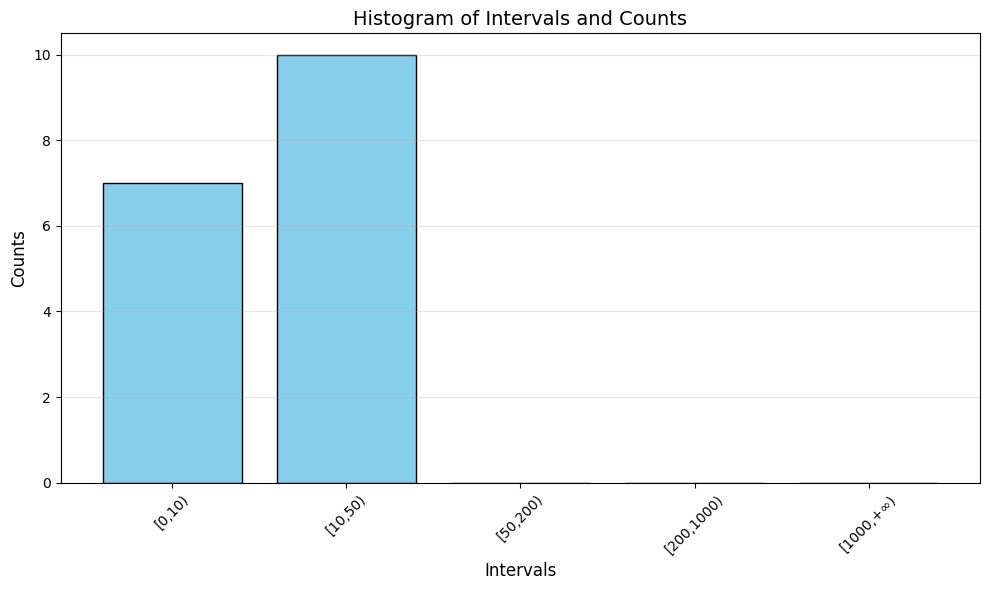

-----------------------------------------------
seed_query_expand_sim_cos
nb pages found in total by crawler :6754
nb relevant pages found in total by crawler :44
Position of last relevant pages : 6485


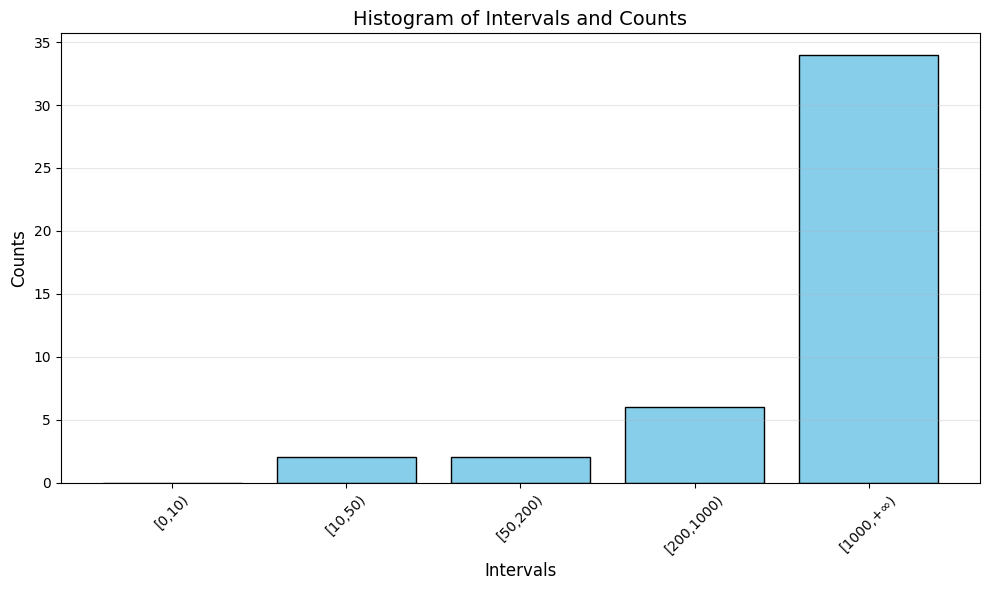

Number of relevant papers found when keeping 50 papers : 2
-----------------------------------------------
seed_query_expand_hyde_sim_cos
nb pages found in total by crawler :6754
nb relevant pages found in total by crawler :44
Position of last relevant pages : 2452


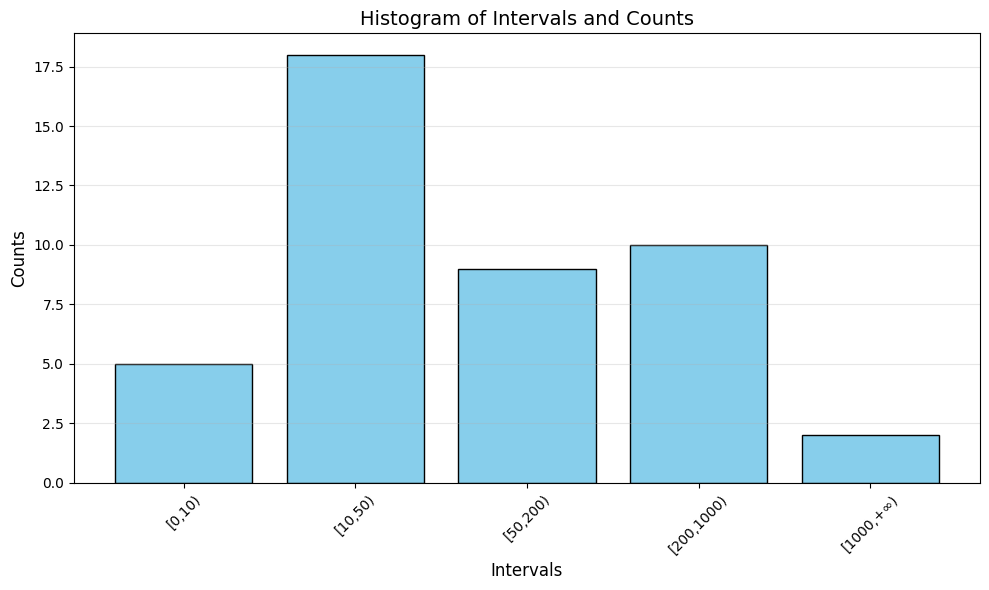

Number of relevant papers found when keeping 50 papers : 23
-----------------------------------------------
most_relevant_expand_hyde_sim_cos
nb pages found in total by crawler :4148
nb relevant pages found in total by crawler :47
Position of last relevant pages : 1619


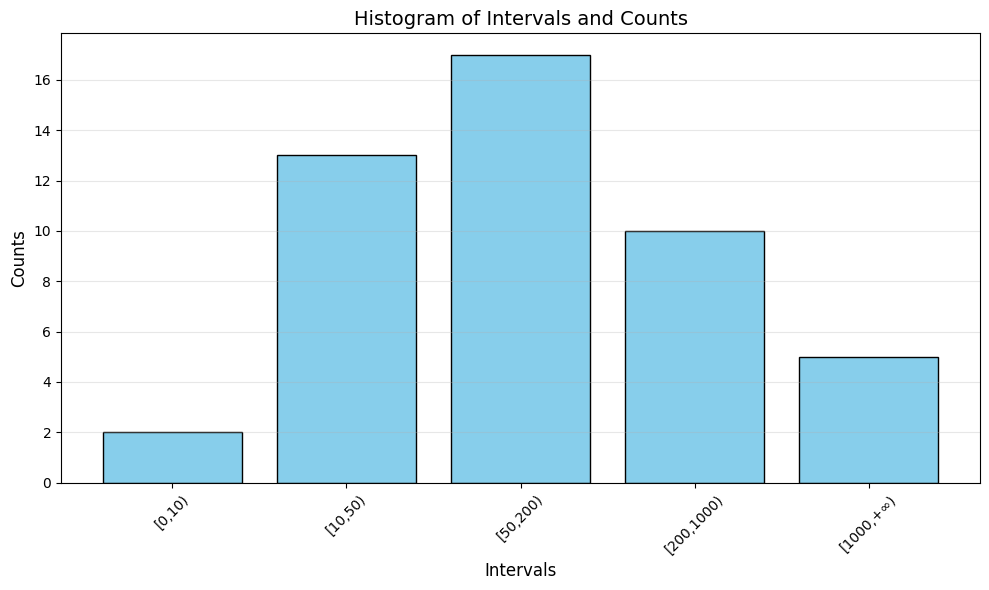

Number of relevant papers found when keeping 50 papers : 15
-----------------------------------------------
most_relevant_expand_hyde_sim_cos_with_prompt
nb pages found in total by crawler :14499
nb relevant pages found in total by crawler :54
Position of last relevant pages : 3636


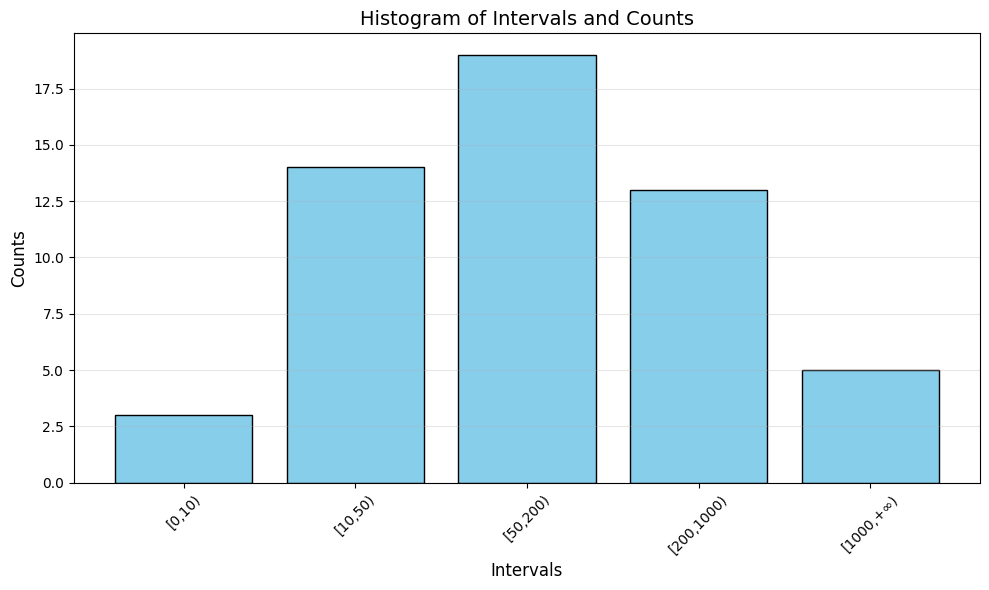

Number of relevant papers found when keeping 50 papers : 17
-----------------------------------------------
seed_query_expand_hyde_sim_cos_with_prompt
nb pages found in total by crawler :14544
nb relevant pages found in total by crawler :54
Position of last relevant pages : 3327


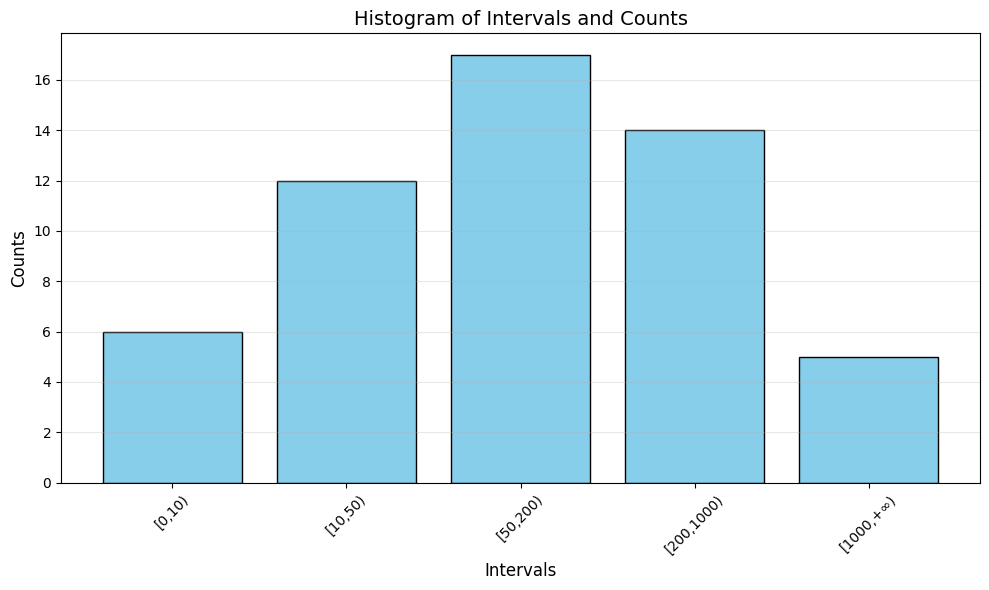

Number of relevant papers found when keeping 50 papers : 18
-----------------------------------------------


In [294]:
## recall and precision evolution by query

labelled_new_papers = pd.read_csv(labelled_new_papers_path)
labelled_dataset = pd.concat([labelled_new_papers,original_dataset], ignore_index=True)
print(f'nb pages total of original dataset:{len(original_dataset)}')
print(f'nb relevant pages of original dataset:{len(original_dataset[original_dataset["relevance"]==1])}')
print(f'nb pages total of labelled dataset:{len(labelled_dataset)}')
print(f'nb relevant pages of labelled dataset:{len(labelled_dataset[labelled_dataset["relevance"]==1])}')
print(f'---For {top_k} presented to the expert---')
for crawler, path in crawlers.items() : 
    print(crawler)
    fetched_pages = pd.read_csv(path + 'fetched_pages.csv')
    session_infos = pd.read_csv(path + 'session.csv')
    print(f'nb pages found in total by crawler :{len(fetched_pages)}')
    print(f'nb relevant pages found in total by crawler :{len(get_relevants(fetched_pages, labelled_dataset))}')
    
    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="right")
    merged_data_sorted = merged_data.sort_values(by="score", ascending=False)
    merged_data_sorted = merged_data_sorted.reset_index(drop=True)
    merged_data_sorted['relevance'] = merged_data_sorted['relevance'].fillna(0)
    relevants_sorted = merged_data_sorted[merged_data_sorted['relevance']==1]
    relevant_positions = relevants_sorted.index.tolist()
    max_position = relevant_positions[-1] if relevant_positions else 0
    print(f'Position of last relevant pages : {max_position}')
    b = [10, 50, 200, 1000]
    bins = [0] + b + [float('inf')]
    counts = [0] * (len(bins) - 1)
    for value in relevant_positions:
        for i in range(len(bins) - 1):
            if bins[i] <= value < bins[i + 1]:
                counts[i] += 1
                break
    intervals = [f"[{bins[i]},{bins[i+1]})" if bins[i+1] != float('inf') else f"[{bins[i]},+∞)" for i in range(len(bins) - 1)]
    result = {interval: count for interval, count in zip(intervals, counts)}
    # print("Résultats par intervalle :")
    # for interval, count in result.items():
    #     print(f"{interval} : {count}")
    categories = list(result.keys())
    values = list(result.values())

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(categories)), values, tick_label=categories, color='skyblue', edgecolor='black')
    plt.xlabel('Intervals', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of Intervals and Counts', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    if crawler == 'baseline':
        query = list(session_infos['all_queries'])[0]
        kept_papers_by_query = {query:fetched_pages.iloc[:100]}
    else : 
        kept_papers_by_query = keep_topk_by_query(session_infos, fetched_pages, top_k)

    i = 1
    for query, papers in kept_papers_by_query.items():
        recall, precision = recall_precision(papers, labelled_dataset)
        # print(f'Query {i}: {query}')
        # print(f'Recall: {recall}, Precision: {precision}')
        if i==10 : 
            print(f'Number of relevant papers found when keeping {top_k} papers : {len(get_relevants(papers, labelled_dataset))}')
        i += 1
    
    print('-----------------------------------------------')

        